In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skhep.dataset.numpydataset import *
import uproot
from skhep.dataset.selection import Selection
import ROOT
from Utilities.utilities import destruct_objects
from Utilities.RooFit import RooDataset, RemoveEmptyBins
from PyLHCb.Root.RooFitUtils import ResidualPlot
import probfit
import iminuit


Welcome to JupyROOT 6.14/06


/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/inspect.py:341: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


In [2]:
# Proxies for RooFit classes
RooFit        = ROOT.RooFit
RooRealVar    = ROOT.RooRealVar
RooArgList    = ROOT.RooArgList
RooArgSet     = ROOT.RooArgSet
RooDataSet    = ROOT.RooDataSet
RooAddPdf     = ROOT.RooAddPdf
RooProdPdf    = ROOT.RooProdPdf
RooExtendPdf  = ROOT.RooExtendPdf
RooConst      = ROOT.RooFit.RooConst
RooConst      = ROOT.RooFit.RooConst
RooExponential= ROOT.RooExponential
RooStats      = ROOT.RooStats
RooGaussian   = ROOT.RooGaussian
RooWorkspace  = ROOT.RooWorkspace
RooWorkspace.rfimport = getattr(RooWorkspace,'import')

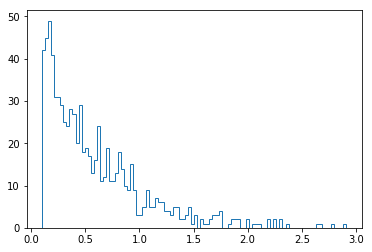

In [3]:
#background only
np.random.seed(10)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 1000)
data = data[(data > 0.1) & (data < 3)]
plt.hist(data, bins=100, histtype='step');

In [4]:
exp_n = probfit.Normalized(probfit.exponential, (0.1,3.))
UL_exp = probfit.UnbinnedLH(exp_n, data)

initial_params = {"lambda":  2.0,  "limit_lambda":    (0.0, 5.0) , "error_lambda"   : 0.05,}

minuit_exp = iminuit.Minuit(UL_exp, **initial_params, pedantic=True)
minuit_exp.migrad();

FCN = 222.38872101313802 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.5280688492127692e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,2.02211,0.0750389,,,0,5,No


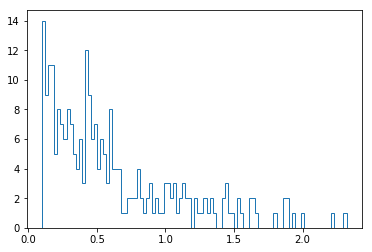

In [5]:
np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > 0.1) & (data < 3)]

plt.hist(data, bins=100, histtype='step');

In [6]:
ws = RooWorkspace("ws")
x = RooRealVar("x","x",0.1,3.0)
ws.rfimport(x)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::x


In [7]:
roodataset = RooDataset( "data", x) 
roodataset.fill( data )
roodataset.Print('v')
roodataset.to_wspace( ws )

DataStore data (data)
  Contains 256 entries
  Observables: 
    1)  x = 1.27812  L(0.1 - 3)  "x"
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset data


In [8]:
### signal
mean = RooConst(1.2)
sigma = RooConst(0.1)
gauss = RooGaussian("signal","signal", x, mean, sigma)
nsig  = RooRealVar("nsig", "nsig", 0, -10, len((data)))
gauss_norm = RooExtendPdf("gauss_norm", "gauss_norm", gauss, nsig)

### background
tau = RooRealVar("tau", "tau", -2.0, -5, -0.1)
exp = RooExponential("bkg","bkg", x, tau)
nbkg  = RooRealVar("nbkg", "nbkg", len(data), 0, len((data))*1.1)
exp_norm = RooExtendPdf("exp_norm", "exp_norm", exp, nbkg)

constraint_tau = RooGaussian("constraint_tau", "constraint_tau", tau, RooConst(-minuit_exp.values["lambda"]), RooConst(minuit_exp.errors["lambda"]))

### total
totpdf = RooAddPdf("totpdf","totpdf",RooArgList(gauss_norm,exp_norm))

#totpdf_c = RooAddPdf("totpdf","totpdf",RooArgList(gauss_norm,exp_norm))

totpdf_c = RooProdPdf("totpdf_c", "totpdf_c", RooArgList(totpdf, constraint_tau))

#ws.rfimport(totpdf)
ws.rfimport(totpdf_c)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooProdPdf::totpdf_c
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooAddPdf::totpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooExtendPdf::gauss_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooGaussian::signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooConstVar::1.2
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooConstVar::0.1
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::nsig
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooExtendPdf::exp_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooExponential::bkg
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::tau
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooRealVar::nbkg
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing RooGaussian::constraint_tau
[#1] 

In [9]:
ws.Print('V')


RooWorkspace(ws) ws contents

variables
---------
(nbkg,nsig,tau,x)

p.d.f.s
-------
RooExponential::bkg[ x=x c=tau ] = 0.0450492
RooGaussian::constraint_tau[ x=tau mean=-2.02211 sigma=0.0750389 ] = 0.957534
RooExtendPdf::exp_norm[ pdf=bkg n=nbkg ] = 0.0450492
RooExtendPdf::gauss_norm[ pdf=signal n=nsig ] = 0.00218749
RooGaussian::signal[ x=x mean=1.2 sigma=0.1 ] = 0.00218749
RooAddPdf::totpdf[ gauss_norm + exp_norm ] = 0.0450492
RooProdPdf::totpdf_c[ totpdf * constraint_tau ] = 0.0431361

datasets
--------
RooDataSet::data(x)



In [10]:
dataset = ws.data("data")
fitResult = totpdf_c.fitTo(dataset, ROOT.RooFit.Extended(), ROOT.RooFit.Minos(ROOT.kFALSE), ROOT.RooFit.Save(ROOT.kTRUE), ROOT.RooFit.Constrain(RooArgSet(tau)))

[#1] INFO:Minization --  Including the following contraint terms in minimization: (constraint_tau)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_totpdf_c_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (signal)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gauss_norm,exp_norm)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nbkg         2.56000e+02  1.28000e+01    0.00000e+00  2.81600e+02
     2 nsig         0.00000e+00  5.00000e+00   -1.00000e+01  2.56000e+02
     3 tau         -2.00000e+00  4.90000e-01   -5.00000e+00 -1.00000e-01
 **********
 **    3 **SET ERR  

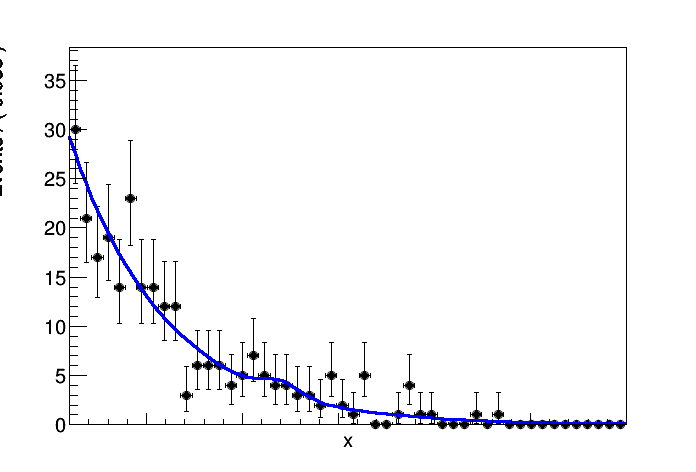

In [11]:
c = ROOT.TCanvas()
frame = x.frame(50)
dataset.plotOn( frame, ROOT.RooFit.Name('data_print'))
RemoveEmptyBins( frame, 'data_print')
totpdf_c.plotOn( frame, ROOT.RooFit.Name('model_print'))
frame.Draw()
Plot = ResidualPlot('title1', frame)
Plot.addResidual( 'data_print', 'model_print', 0.1, 3.0)
Plot.plot()
Plot.canvas.GetListOfPrimitives().At(0).cd()
c.Draw()

In [12]:
ws.defineSet('POI', "nsig")
ws.defineSet('OBS', 'x')
ws.defineSet('NUI', 'nbkg,tau')

conf = RooStats.ModelConfig('model', ws)
conf.SetPdf(ws.pdf('totpdf_c'))
conf.SetParametersOfInterest(ws.set('POI'))
conf.SetObservables(ws.set('OBS'))
conf.SetNuisanceParameters(ws.set('NUI'))

POI = ws.set('POI')
    
poi = POI.first()

    
#S+B model
model_sb = conf
model_sb.SetName("MODEL_SB")
#poi.setVal(35)
model_sb.SetSnapshot(RooArgSet(poi))
    
#BKG only 
model_b = conf.Clone()
model_b.SetName("MODEL_B")
oldval = poi.getVal()
poi.setVal(0)
model_b.SetSnapshot( RooArgSet(poi) )

#poi.setVal(oldval)
    
ws.rfimport(model_sb)
ws.rfimport(model_b)

False

In [13]:
data = ws.data("data")
model_sb = ws.obj('MODEL_SB')
model_b = ws.obj('MODEL_B')
    
data.Print()
model_b.Print()
model_sb.Print()

RooDataSet::data[x] = 256 entries

=== Using the following for MODEL_B ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsig)
Nuisance Parameters:     RooArgSet:: = (nbkg,tau)
PDF:                     RooProdPdf::totpdf_c[ totpdf * constraint_tau ] = 0.0431361
Snapshot:                
  1) 0x7fe383350840 RooRealVar:: nsig = 0  L(-10 - 256)  "nsig"


=== Using the following for MODEL_SB ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsig)
Nuisance Parameters:     RooArgSet:: = (nbkg,tau)
PDF:                     RooProdPdf::totpdf_c[ totpdf * constraint_tau ] = 0.0431361
Snapshot:                
  1) 0x7fe383350840 RooRealVar:: nsig = 0  L(-10 - 256)  "nsig"



In [14]:
#Execution
#calc = ROOT.RooStats.FrequentistCalculator(data, model_b, model_sb)
#calc.SetToys(2000,1000)

calc = ROOT.RooStats.AsymptoticCalculator(data, model_b, model_sb)
calc = ROOT.RooStats.AsymptoticCalculator(data, model_sb, model_b)
calc.SetOneSided(True)
calc.SetQTilde(False)
#calc.SetPrintLevel(0)
#calc.SetOneSidedDiscovery(True) 

[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   10 **SET PRINT           0
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nbkg         2.56000e+02  1.28000e+01    0.00000e+00  2.81600e+02
     2 nsig         0.00000e+00  5.00000e+00   -1.00000e+01  2.56000e+02
     3 tau         -2.00000e+00  4.90000e-01   -5.00000e+00 -1.00000e-01
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET STR           1
 **********
 **********
 **   15 **MIGRAD        1500           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=-1077.31 FROM

In [15]:
res = calc.GetHypoTest()
#res = ROOT.RooStats.HypoTestInverter(calc)
res.Print()


[#1] INFO:Eval -- AsymptoticCalculator::GetHypoTest: - perform  an hypothesis test for  POI ( nsig ) = 0
[#0] PROGRESS:Eval -- AsymptoticCalculator::GetHypoTest -  Find  best conditional NLL on OBSERVED data set ..... 
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nbkg         2.50449e+02  1.64864e+01    0.00000e+00  2.81600e+02
     2 tau         -2.00213e+00  6.66477e-02   -5.00000e+00 -1.00000e-01
 **********
 **   15 **SET ERR         0.5
 **********
 **********
 **   16 **SET PRINT           0
 **********
 **********
 **   17 **SET STR           1
 **********
 **********
 **   18 **MIGRAD        1000           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=-1076.71 FROM MIGRAD    STAT

In [16]:
test = RooStats.HypoTestInverter(calc)
test.SetConfidenceLevel(0.95)
test.UseCLs(True)
    
toysmc = test.GetHypoTestCalculator().GetTestStatSampler()
#RooStats.ProfileLikelihoodTestStat.SetAlwaysReuseNLL(True)
profil = RooStats.ProfileLikelihoodTestStat(model_sb.GetPdf())
profil.SetOneSided(True)
toysmc.SetTestStatistic(profil)

test.SetFixedScan(10, 0.1, 25)
r = test.GetInterval()
r.Print()

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : MODEL_B
		 using as B (alternate) model  : MODEL_SB

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(ws) replacing previous snapshot with name MODEL_B__snapshot

[#1] INFO:Eval -- AsymptoticCalculator::GetHypoTest: - perform  an hypothesis test for  POI ( nsig ) = 0.1
[#0] PROGRESS:Eval -- AsymptoticCalculator::GetHypoTest -  Find  best conditional NLL on OBSERVED data set ..... 
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   25 **SET PRINT           0
 **********
 **********
 **   26 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nbkg         2.50449e+02  1.64864e+01    0.00000e+00  2.81600e+02
     2 tau         -2.00213e+00  6.66477e-02   -5.00000e+00 -1.00000e-01
 **********
 ** 

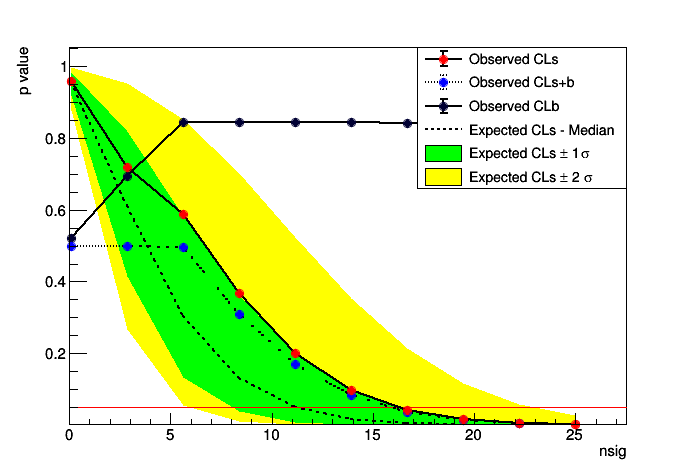

In [17]:
plot = RooStats.HypoTestInverterPlot("alla","blabal", r)
c = ROOT.TCanvas("Scan")
plot.Draw("CLb 2CL")
c.Draw()

In [18]:
print("\n \n")
print("Obs upper limit {0}".format(r.UpperLimit()))
print("Exp upper limit {0}".format(r.GetExpectedUpperLimit(0)))
print("Exp upper limit 1sigma {0}".format(r.GetExpectedUpperLimit(1)))
print("Exp upper limit 2sigma {0}".format(r.GetExpectedUpperLimit(2)))
print("Exp upper limit -1sigma {0}".format(r.GetExpectedUpperLimit(-1)))
print("Exp upper limit -2sigma {0}".format(r.GetExpectedUpperLimit(-2)))


 

Obs upper limit 16.31595346878048
Exp upper limit 11.134016470719184
Exp upper limit 1sigma 16.284566607219542
Exp upper limit 2sigma 23.0134968506318
Exp upper limit -1sigma 8.049911292177265
Exp upper limit -2sigma 5.894222314534799


#### 